#### Import


In [455]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [456]:
DATA_PATH_TRAIN = "data/train.csv"
df = pd.read_csv(DATA_PATH_TRAIN)
DATA_PATH_TEST = "data/train.csv"
test = pd.read_csv(DATA_PATH_TEST)
df.head()

,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,...,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2010-06-26,27.0,66829.0,549.0,17290.0,60.0,Divorced,1.0,Rent,1095.0,...,Employed,Associate,4.0,35067.0,0.257790,0.251465,508.970230,0.288013,0.0,66.176500
1,1996-09-23,55.0,172147.0,850.0,16110.0,36.0,Widowed,1.0,Mortgage,211.0,...,Employed,High School,33.0,27001.0,0.086110,0.093173,514.675859,0.050585,1.0,28.495737
2,2015-01-19,51.0,300000.0,850.0,38436.0,36.0,Married,0.0,Mortgage,546.0,...,Employed,Bachelor,28.0,278382.0,0.108436,0.115443,1268.276385,0.072571,1.0,34.488104
3,1981-05-12,25.0,34683.0,847.0,19186.0,48.0,Married,0.0,Other,153.0,...,Employed,High School,0.0,9224.0,0.100686,0.112822,498.505187,0.225415,1.0,36.910753
4,1995-05-07,55.0,300000.0,850.0,30437.0,48.0,Single,2.0,Rent,562.0,...,Employed,Bachelor,31.0,4502.0,0.110437,0.089037,756.035156,0.052721,1.0,31.347091


#### Разбираем дату

In [457]:
def data_processing(df):
    df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'], format='%Y-%m-%d')
    df['application_year'] = df['ApplicationDate'].dt.year
    df['application_month'] = df['ApplicationDate'].dt.month
    df['application_day_of_week'] = df['ApplicationDate'].dt.dayofweek
    df = df.drop('ApplicationDate', axis=1)
    return df

#### One hot encoding

In [458]:
def one_hot(df):
    return pd.get_dummies(df, columns=['MaritalStatus', 'HomeOwnershipStatus', 'EmploymentStatus', 'EducationLevel', 'LoanPurpose'], drop_first=True)


#### Ищем корреляции

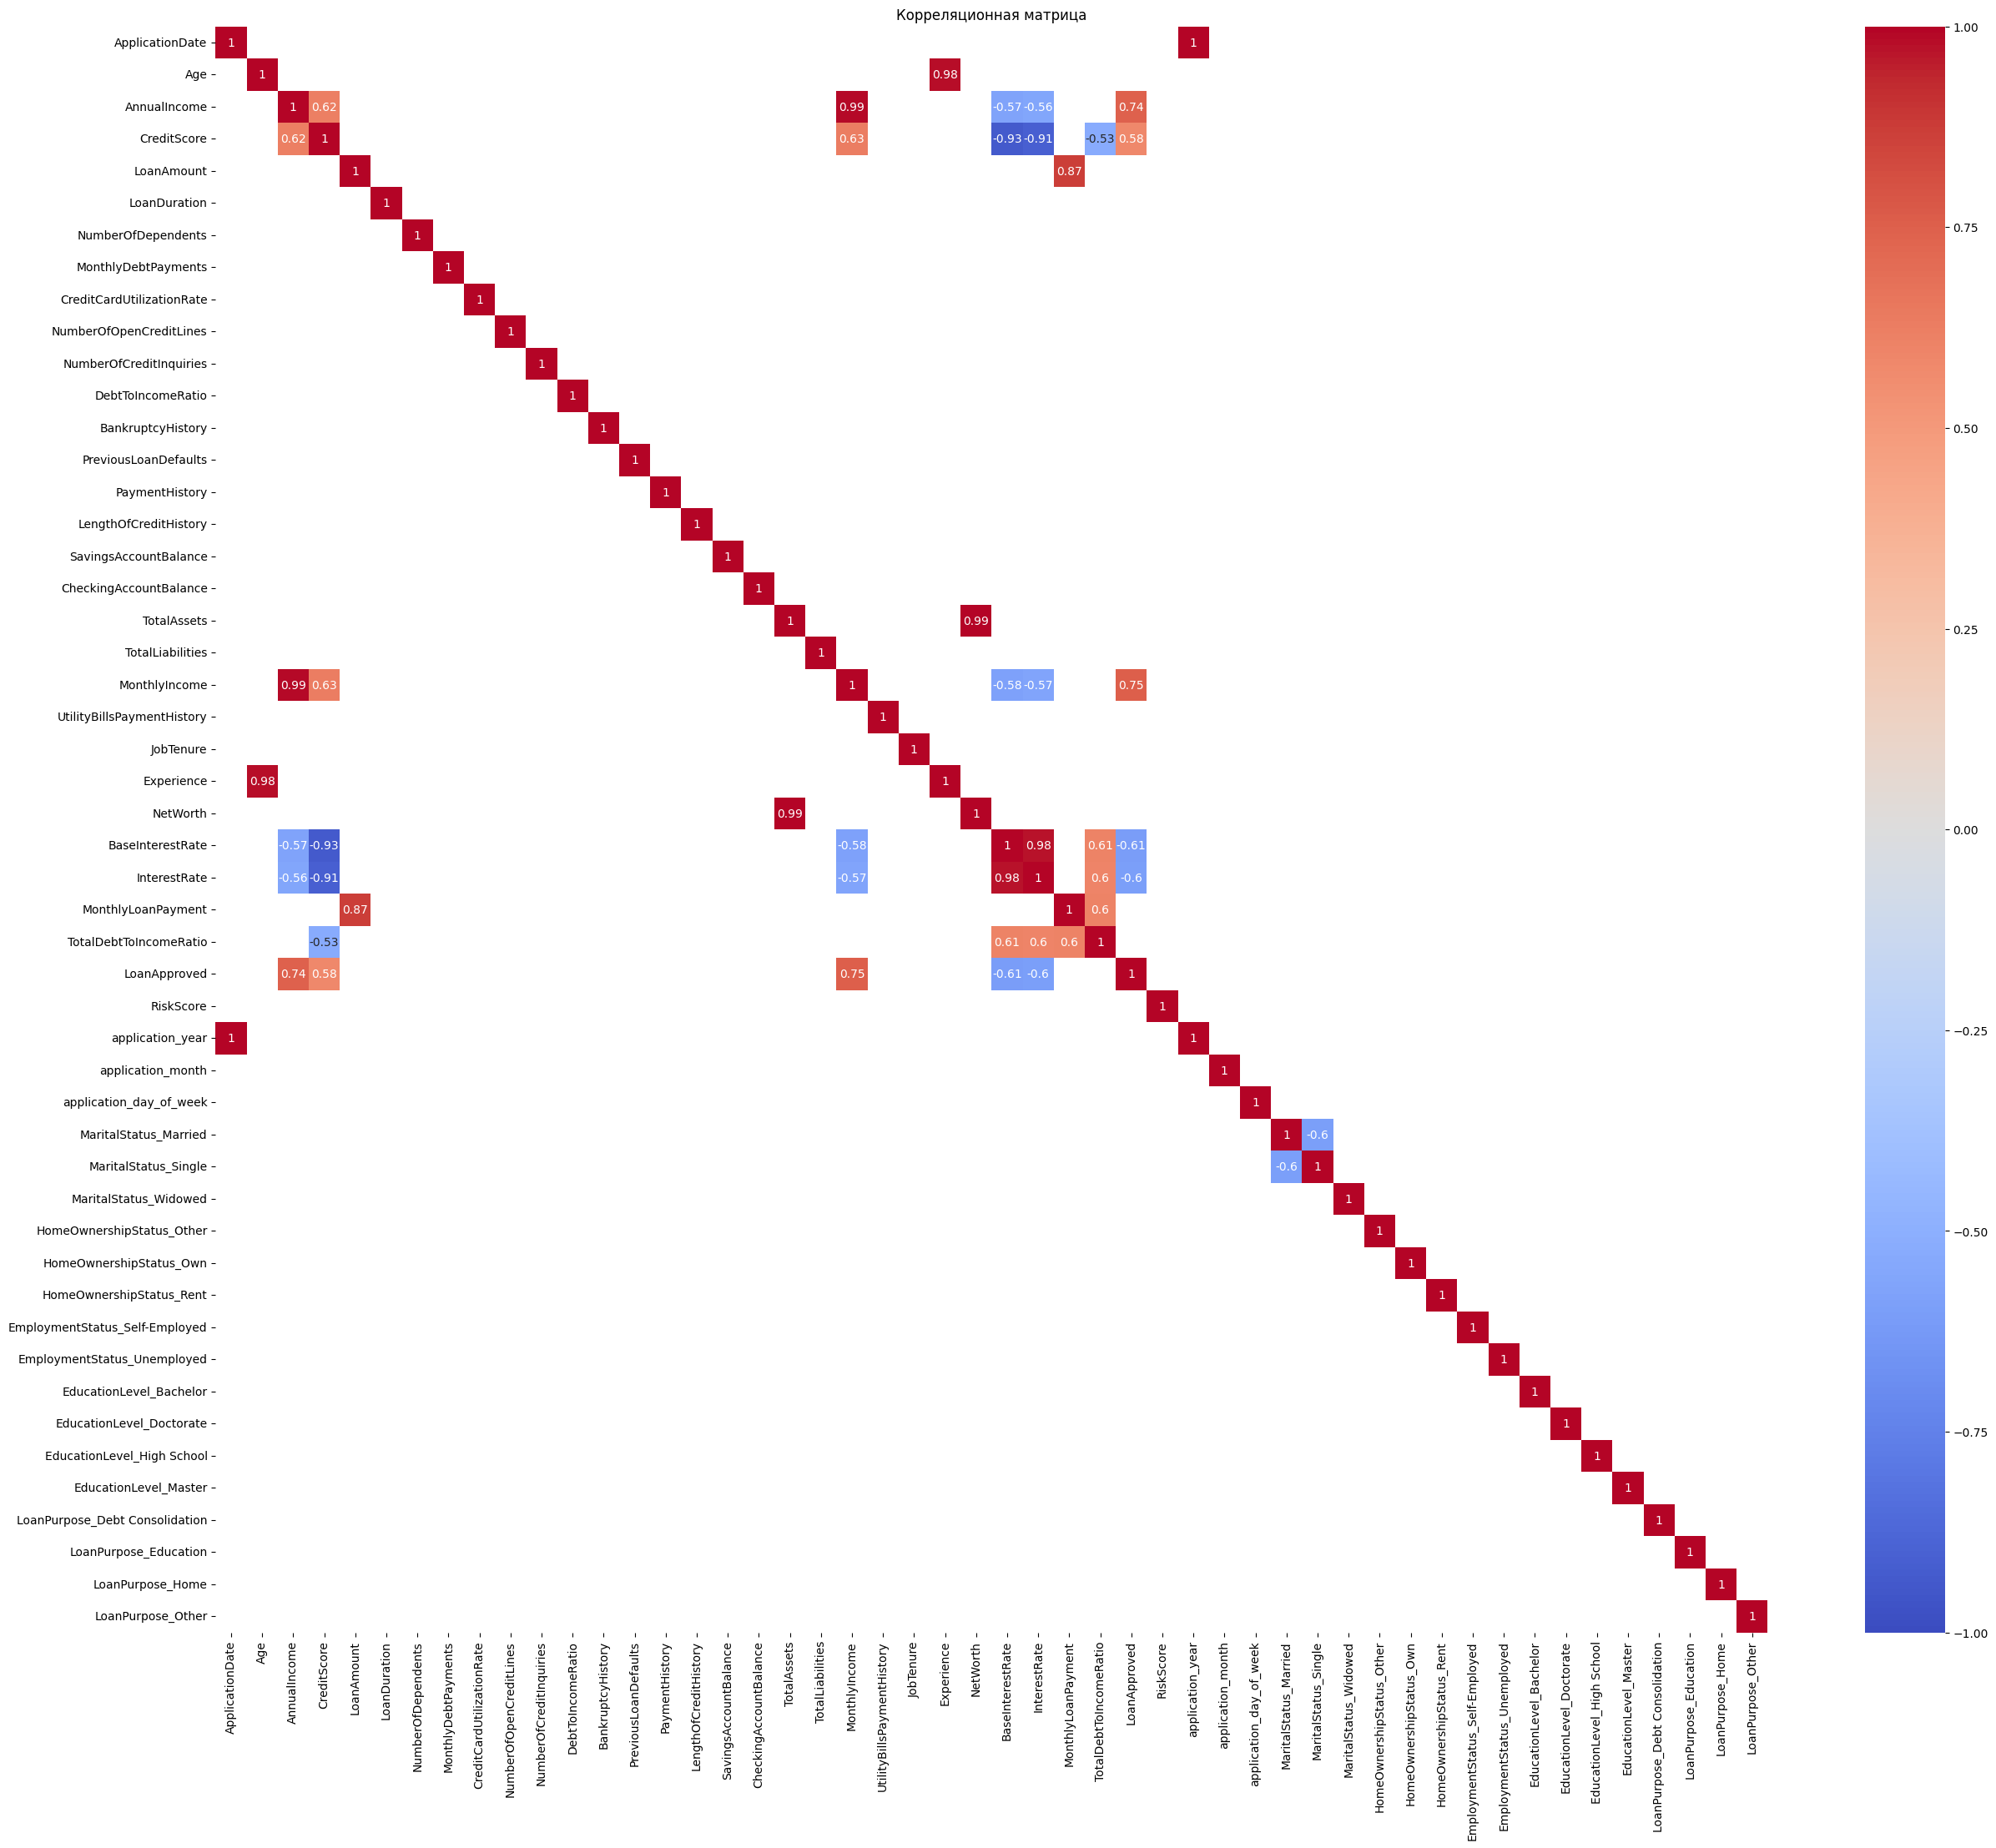

In [459]:
df_tmp = data_processing(df)
df_tmp = one_hot(df)

corr_matrix = df_tmp.corr()
mask = (corr_matrix.abs() >= 0.5)
plt.figure(figsize=(30, 25))
sns.heatmap(corr_matrix[mask], annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Корреляционная матрица")
plt.show()

def drop_corr(df):
    return df.drop(['Experience', 'MonthlyIncome', 'LoanApproved', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalAssets'], axis = 1) # annual income + CreditScore
    

#### Графики для нормализации

Plotting histogram for: Age
Plotting histogram for: AnnualIncome
Plotting histogram for: CreditScore
Plotting histogram for: LoanAmount
Plotting histogram for: LoanDuration
Plotting histogram for: NumberOfDependents
Plotting histogram for: MonthlyDebtPayments
Plotting histogram for: CreditCardUtilizationRate
Plotting histogram for: NumberOfOpenCreditLines
Plotting histogram for: NumberOfCreditInquiries
Plotting histogram for: DebtToIncomeRatio
Plotting histogram for: BankruptcyHistory
Plotting histogram for: PreviousLoanDefaults
Plotting histogram for: PaymentHistory
Plotting histogram for: LengthOfCreditHistory
Plotting histogram for: SavingsAccountBalance
Plotting histogram for: CheckingAccountBalance
Plotting histogram for: TotalAssets
Plotting histogram for: TotalLiabilities
Plotting histogram for: MonthlyIncome
Plotting histogram for: UtilityBillsPaymentHistory
Plotting histogram for: JobTenure
Plotting histogram for: Experience
Plotting histogram for: NetWorth
Plotting histogram 

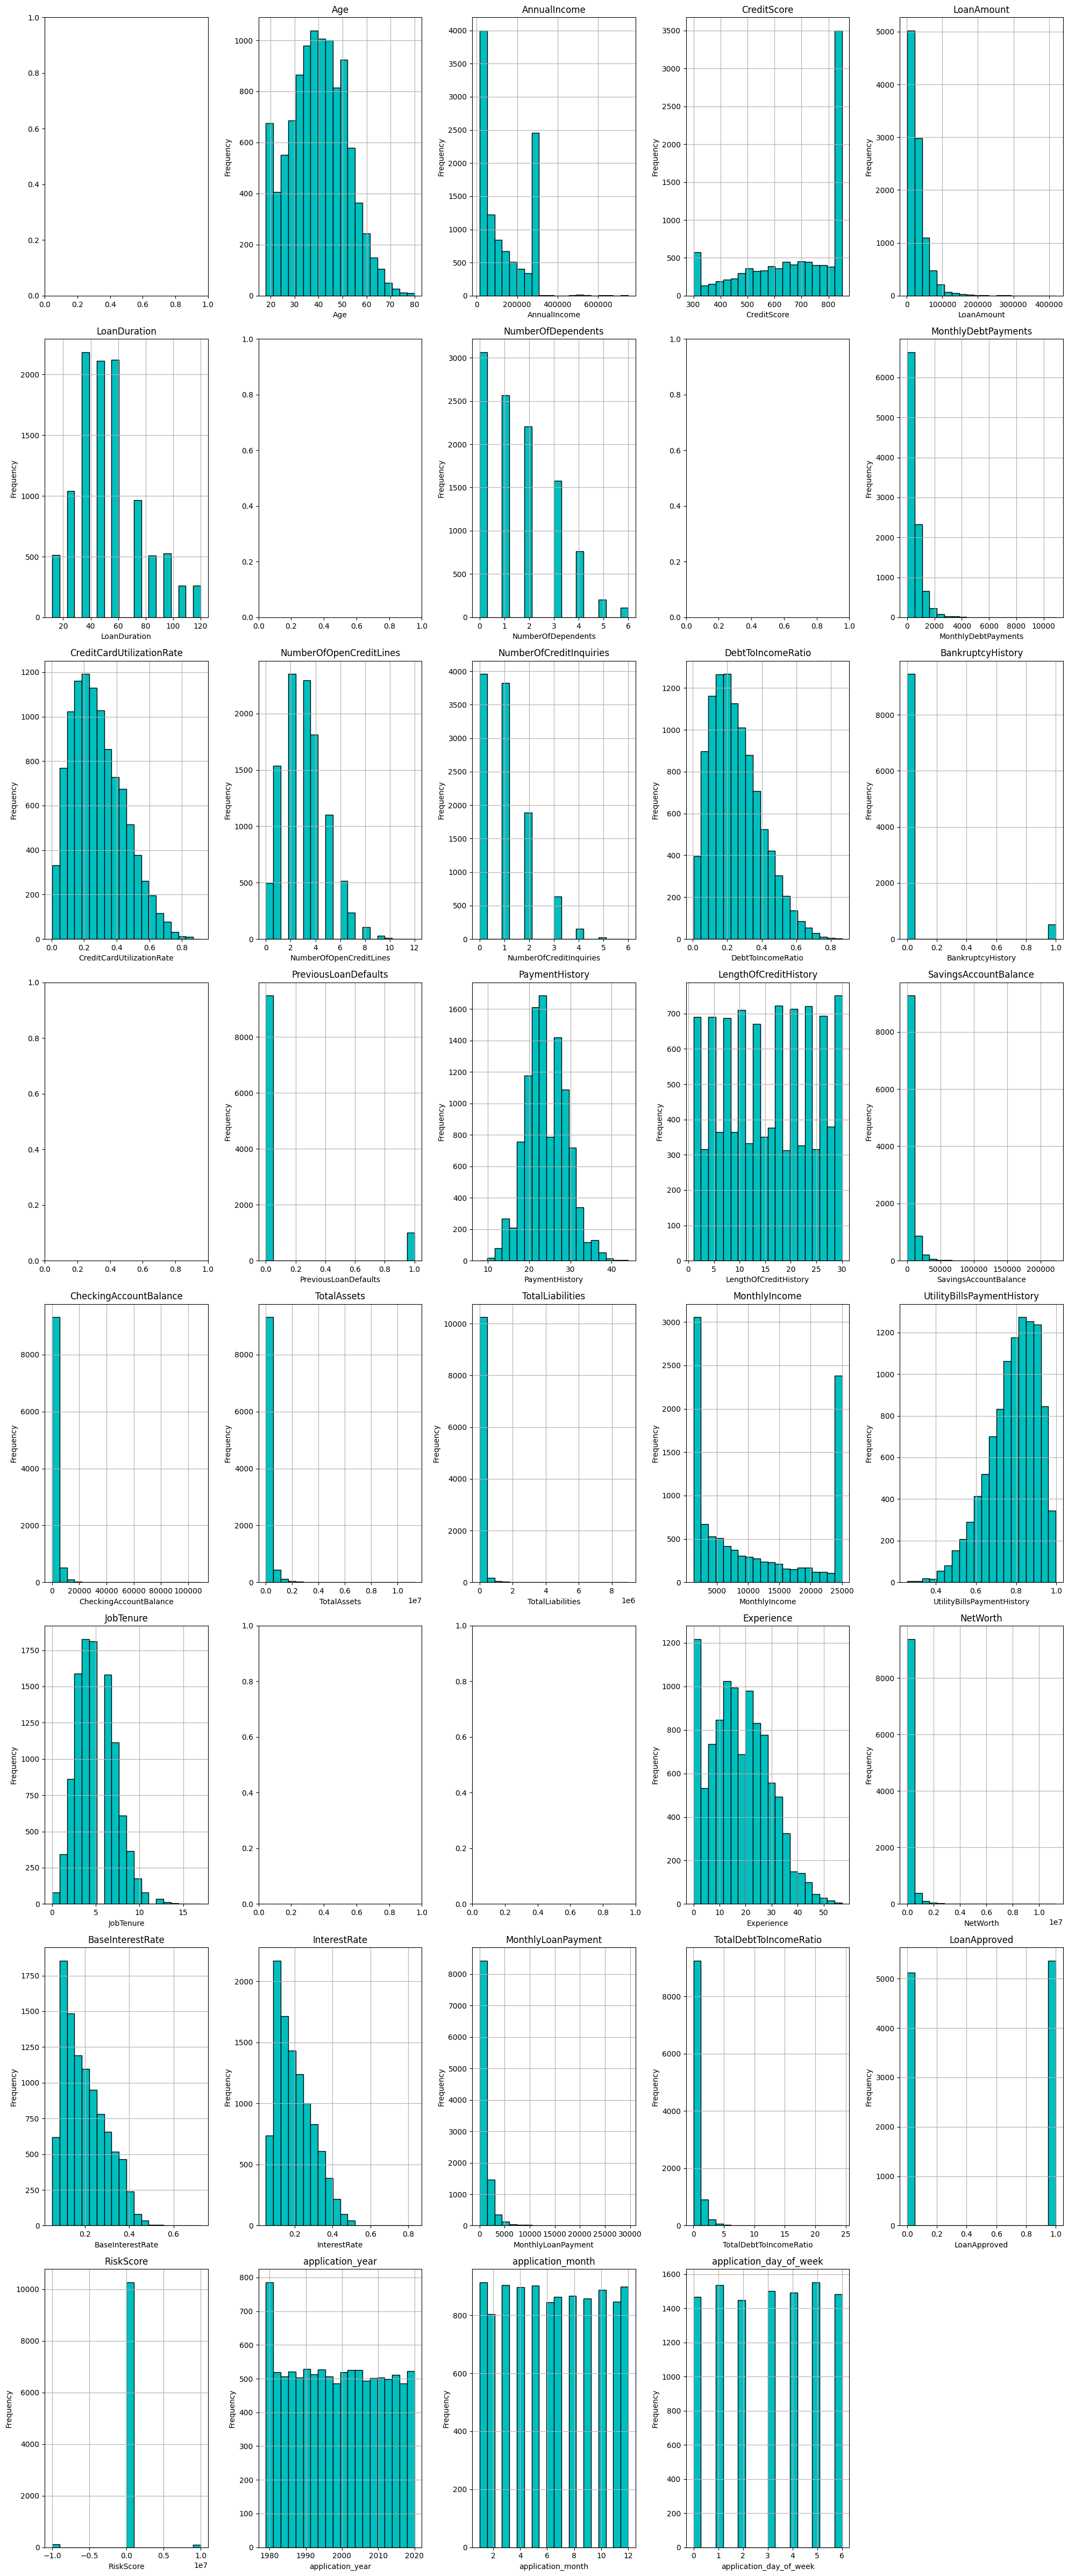

In [466]:
num_columns = len(df.columns)

nrows = 8

fig, axes = plt.subplots(nrows=nrows, ncols=5, figsize=(20, 6*nrows))

axes = axes.ravel()

for i, col in enumerate(df.columns):
    if pd.api.types.is_numeric_dtype(df[col]):
        print(f'Plotting histogram for: {col}')
        try:
            df[col].hist(ax=axes[i], bins=20, color='c', edgecolor='black')
            axes[i].set_title(col)
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
        except Exception as e:
            print(f'Error plotting {col}: {e}')  # Для отладки

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Нормализация

In [489]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error

scalerMinMax = MinMaxScaler()
scalerStandart = StandardScaler()

def normalize(df):

    standart_colums = ['Age', 'LoanDuration', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'DebtToIncomeRatio', 
                       'PaymentHistory', 'UtilityBillsPaymentHistory', 'JobTenure']
    minimax_colums = ['CreditScore', 'NumberOfDependents', 'LengthOfCreditHistory', 'application_year', 'application_month', 'application_day_of_week']
    log_colums = ['AnnualIncome', 'LoanAmount', 'MonthlyDebtPayments', 'NumberOfCreditInquiries', 'SavingsAccountBalance', 
                  'CheckingAccountBalance', 'TotalLiabilities', 'NetWorth', 'TotalDebtToIncomeRatio']
    
    df[standart_colums] = scalerStandart.fit_transform(df[standart_colums])
    df[minimax_colums] = scalerMinMax.fit_transform(df[minimax_colums])
    df[log_colums] = np.log1p(df[log_colums])
    df[log_colums] = scalerStandart.fit_transform(df[log_colums])

    return df

def proccesing(df):
    df = data_processing(df)
    df = one_hot(df)
    df = drop_corr(df)
    df = normalize(df)
    df[df.select_dtypes(include=[bool]).columns] = df.select_dtypes(include=[bool]).astype(int)
    df = df.dropna(how='all')
    df = df.fillna(df.median())
    df = df[(df['RiskScore'] >= -10000) & (df['RiskScore'] <= 10000)]
    df = df.drop_duplicates()
    return df

In [491]:
df_proc = proccesing(df)
test_proc = proccesing(test)
model = Ridge(alpha = 1)
X = df_proc.drop('RiskScore', axis=1)
y = df_proc['RiskScore']
model.fit(X, y)


y_test = test_proc['RiskScore']
X_test = test_proc.drop('RiskScore', axis=1)

y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_pred, y_test))



MSE: 42.47290941251817
